# STAT 306 2024W2 - Project: Report

# Group Project Report

## Outline

1.  fit linear model with all covariates
2.  multi-collinearity check correlation among covariates (VIF)
3.  assumptions
4.  residual pattern -\> transformation
5.  model selection (forward R^2, backward max p-value, CP)
6.  interaction term
7.  (optional) outlier, leverage, influence
8.  anova

## Data Preparation

The response variable \`SalePrice\` column is divided by 1,000, so the
unit for response variable is 1 thousand dollar.



In [3]:
library(car)
library(leaps)
library(knitr)  # TODO
library(kableExtra) # TODO
library(olsrr)


# options(repr.matrix.max.rows = 20)

ames_housing <- read.table("https://raw.githubusercontent.com/AllenCheng5186/STAT306-G14-Group-Project/refs/heads/main/data/ames-housing.csv", sep = ",", header=T)

ames_housing$SalePrice <- ames_housing$SalePrice / 10000

house = ames_housing[, c("SalePrice", "Overall.Qual", "Gr.Liv.Area",
                         "Garage.Area", "Year.Built", "Lot.Area",
                         "Bedroom.AbvGr", "Kitchen.AbvGr", "Lot.Shape",
                         "Utilities", "Yr.Sold", "Central.Air",
                         "Electrical", "TotRms.AbvGrd")]

house[sapply(house, is.character)] <- lapply(house[sapply(house, is.character)], as.factor)
# house$Overall.Qual <- as.factor(house$Overall.Qual)
house[is.na(house)] <- 0

head(house)

,SalePrice,Overall.Qual,Gr.Liv.Area,Garage.Area,Year.Built,Lot.Area,Bedroom.AbvGr,Kitchen.AbvGr,Lot.Shape,Utilities,Yr.Sold,Central.Air,Electrical,TotRms.AbvGrd
,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<int>
1,21.50,6,1656,528,1960,31770,3,1,IR1,AllPub,2010,Y,SBrkr,7
2,10.50,5,896,730,1961,11622,2,1,Reg,AllPub,2010,Y,SBrkr,5
3,17.20,6,1329,312,1958,14267,3,1,IR1,AllPub,2010,Y,SBrkr,6
4,24.40,7,2110,522,1968,11160,3,1,Reg,AllPub,2010,Y,SBrkr,8
5,18.99,5,1629,482,1997,13830,3,1,IR1,AllPub,2010,Y,SBrkr,6
6,19.55,6,1604,470,1998,9978,3,1,IR1,AllPub,2010,Y,SBrkr,7


## Model Selection

forward selection

In [4]:
# {r}
#| echo: false
#| message: false
#| warning: false
#| output: false
# Replace SalePrice values with log-transformed values
house$SalePrice <- log(house$SalePrice)

# Optionally rename the column (if you want to reflect it's log-transformed)
names(house)[names(house) == "SalePrice"] <- "log_SalePrice"

full_model <- lm(log_SalePrice ~ ., data = house)

forward <- ols_step_forward_r2(full_model)

forward$metrics

step,variable,r2,adj_r2,aic,sbc,sbic
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Overall.Qual,0.6816896,0.6815809,-293.4308,-275.4826,-8610.709
2,Gr.Liv.Area,0.7566061,0.7564398,-1077.6846,-1053.7535,-9394.657
3,Year.Built,0.7950538,0.7948436,-1579.4492,-1549.5354,-9895.853
4,Garage.Area,0.8085233,0.8082614,-1776.6345,-1740.7379,-10092.763
5,Central.Air,0.8178371,0.8175256,-1920.7384,-1878.8591,-10236.531
6,Lot.Area,0.8250381,0.8246789,-2036.9142,-1989.0522,-10352.296
7,Lot.Shape,0.8278358,0.8273052,-2078.1453,-2012.3350,-10397.331
8,Kitchen.AbvGr,0.8294062,0.8288218,-2102.9941,-2031.2010,-10422.041
9,Electrical,0.8302424,0.8293686,-2107.3912,-2005.6843,-10434.348


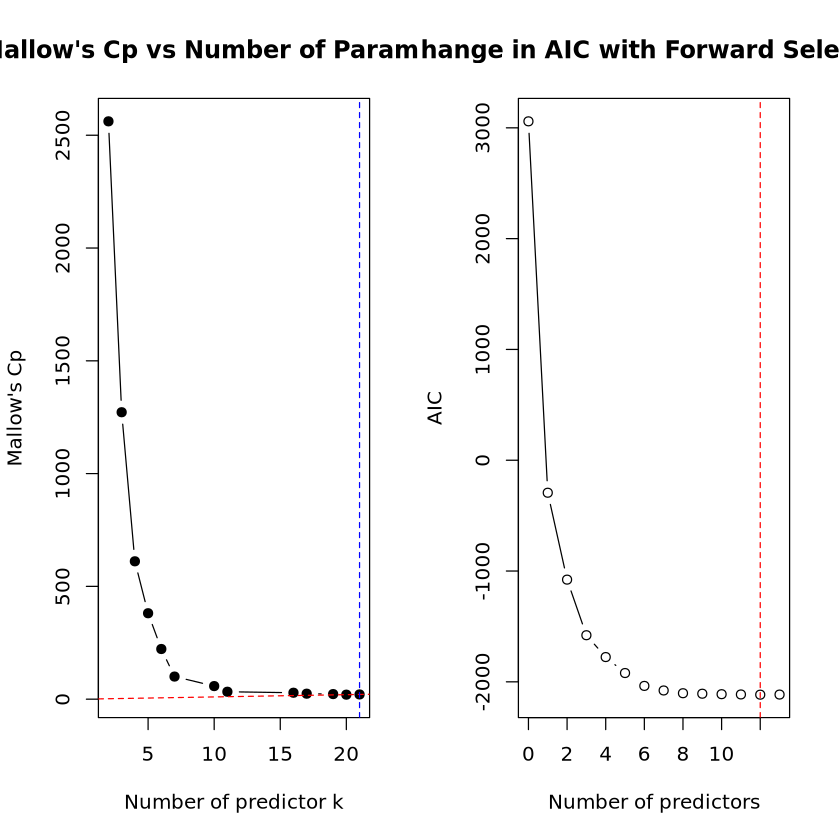

In [5]:
# {r fig.height=5,fig.width=10}
#| echo: false
#| message: false
#| warning: false
#| output: true

cp_scores <- numeric(length = length(forward$metrics$variable))
num_params <- numeric(length = length(forward$metrics$variable))
cp_diff <- numeric(length = length(forward$metrics$variable))

# Mallow's Cp
for (i in seq_along(forward$metrics$variable)) {
  predictors <- forward$metrics$variable[1:i]
  formula_str <- paste("log_SalePrice ~", paste(predictors, collapse = " + "))
  model_i <- lm(as.formula(formula_str), data = house)
  cp_val <- ols_mallows_cp(model_i, full_model)
  cp_scores[i] <- cp_val
  num_params[i] <- length(coef(model_i)) + 1
  cp_diff[i] = cp_val - (length(predictors) + 1)
}

# AIC
predictors <- setdiff(names(house), c("log_SalePrice"))

# Initialize
selected <- c()
aic_values <- numeric()           # Store AIC at each step
num_predictors <- numeric()       # Number of predictors at each step

# Start with intercept-only model
current_formula <- as.formula("log_SalePrice ~ 1")
current_model <- lm(current_formula, data = house)
aic_values[1] <- AIC(current_model)
num_predictors[1] <- 0

# Forward selection loop
for (i in seq_along(predictors)) {
  remaining <- setdiff(predictors, selected)
  
  # Try adding each remaining variable and calculate AIC
  aic_candidates <- sapply(remaining, function(var) {
    temp_formula <- as.formula(paste("log_SalePrice ~", paste(c(selected, var), collapse = " + ")))
    AIC(lm(temp_formula, data = house))
  })
  
  # Select the variable that gives the lowest AIC
  best_var <- names(which.min(aic_candidates))
  selected <- c(selected, best_var)
  
  # Refit the model with updated predictors
  current_formula <- as.formula(paste("log_SalePrice ~", paste(selected, collapse = " + ")))
  current_model <- lm(current_formula, data = house)
  
  # Store metrics
  aic_values[i + 1] <- AIC(current_model)
  num_predictors[i + 1] <- length(selected)
}


par(mfrow = c(1, 2))
# Plot Cp vs p
plot(
  num_params - 1,
  cp_scores, type = "b", pch = 19,
     xlab = "Number of predictor k",
     ylab = "Mallow's Cp",
     main = "Mallow's Cp vs Number of Parameters")
abline(0, 1, col = "red", lty = 2)
# abline(v = which.min(which(cp_diff > 0)), col = "blue", lty = 2)
# Find index of the smallest positive cp_diff

valid_cp <- which(cp_diff > 0)
best_cp_index <- valid_cp[which.min(cp_diff[valid_cp])]

# Correct vertical line
abline(v = num_params[best_cp_index] - 1, col = "blue", lty = 2)
       
# Plot AIC vs. number of predictors
plot(0:length(predictors), aic_values, type = "b",
     xlab = "Number of predictors", ylab = "AIC",
     main = "Change in AIC with Forward Selection")

min_index <- which.min(aic_values)
min_num_pred <- num_predictors[min_index]
abline(v = min_num_pred, col = "red", lty = 2)

In [6]:
selected_vars <- c("log_SalePrice", forward$metrics$variable[1:12])
house <- house[selected_vars]
head(house)

,log_SalePrice,Overall.Qual,Gr.Liv.Area,Year.Built,Garage.Area,Central.Air,Lot.Area,Lot.Shape,Kitchen.AbvGr,Electrical,Bedroom.AbvGr,Utilities,TotRms.AbvGrd
,<dbl>,<int>,<int>,<int>,<dbl>,<fct>,<int>,<fct>,<int>,<fct>,<int>,<fct>,<int>
1,3.068053,6,1656,1960,528,Y,31770,IR1,1,SBrkr,3,AllPub,7
2,2.351375,5,896,1961,730,Y,11622,Reg,1,SBrkr,2,AllPub,5
3,2.844909,6,1329,1958,312,Y,14267,IR1,1,SBrkr,3,AllPub,6
4,3.194583,7,2110,1968,522,Y,11160,Reg,1,SBrkr,3,AllPub,8
5,2.943913,5,1629,1997,482,Y,13830,IR1,1,SBrkr,3,AllPub,6
6,2.972975,6,1604,1998,470,Y,9978,IR1,1,SBrkr,3,AllPub,7


These two plots shows we can use 9 covariates in our final model.

From the plot of Mallow’s CP score, the score more close to number of
parameter (p+1) means better

From the plot of AIC, the AIC score lower mean better.

Then we decided to use top 9 covariates from forward selection, which
covariate that has strongest relationship during each iteration in the
greedy algorithm

## Multi-collinearity check

calculate VIF to verify that there is not strong correlation between any
continuous variables.

why use VIF? What is the advantage of using VIF? Using thumb theory of
10 as cutoff, since every continuous variable does not over 10, so no
multi-collinearity.

explain what is multi-collinearity -\> any correlation among explanatory
variables (X)

 Overall.Qual   Gr.Liv.Area    Year.Built   Garage.Area      Lot.Area 
     2.581993      4.143036      1.716424      1.725470      1.125973 
Kitchen.AbvGr Bedroom.AbvGr TotRms.AbvGrd 
     1.224301      2.023617      4.217874 

## Fit full model (using all covariates)

verify assumption: residual vs fitted value plot

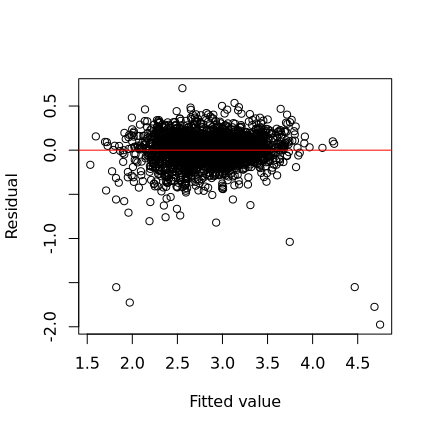

funnel pattern appear

linear regression assumption: homoscedasticity $Var(\Sigma)  = \sigma^2$
violated

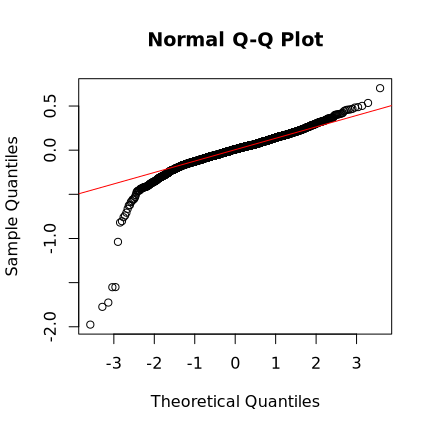

heavy tail observed -\> homoscedasticity $Var(\Sigma) = \sigma^2$
violated

## Log(Y) Transformation

take log on response variable Y, log(Y)

create scatterplot between log(Y) and each continuous variables of X

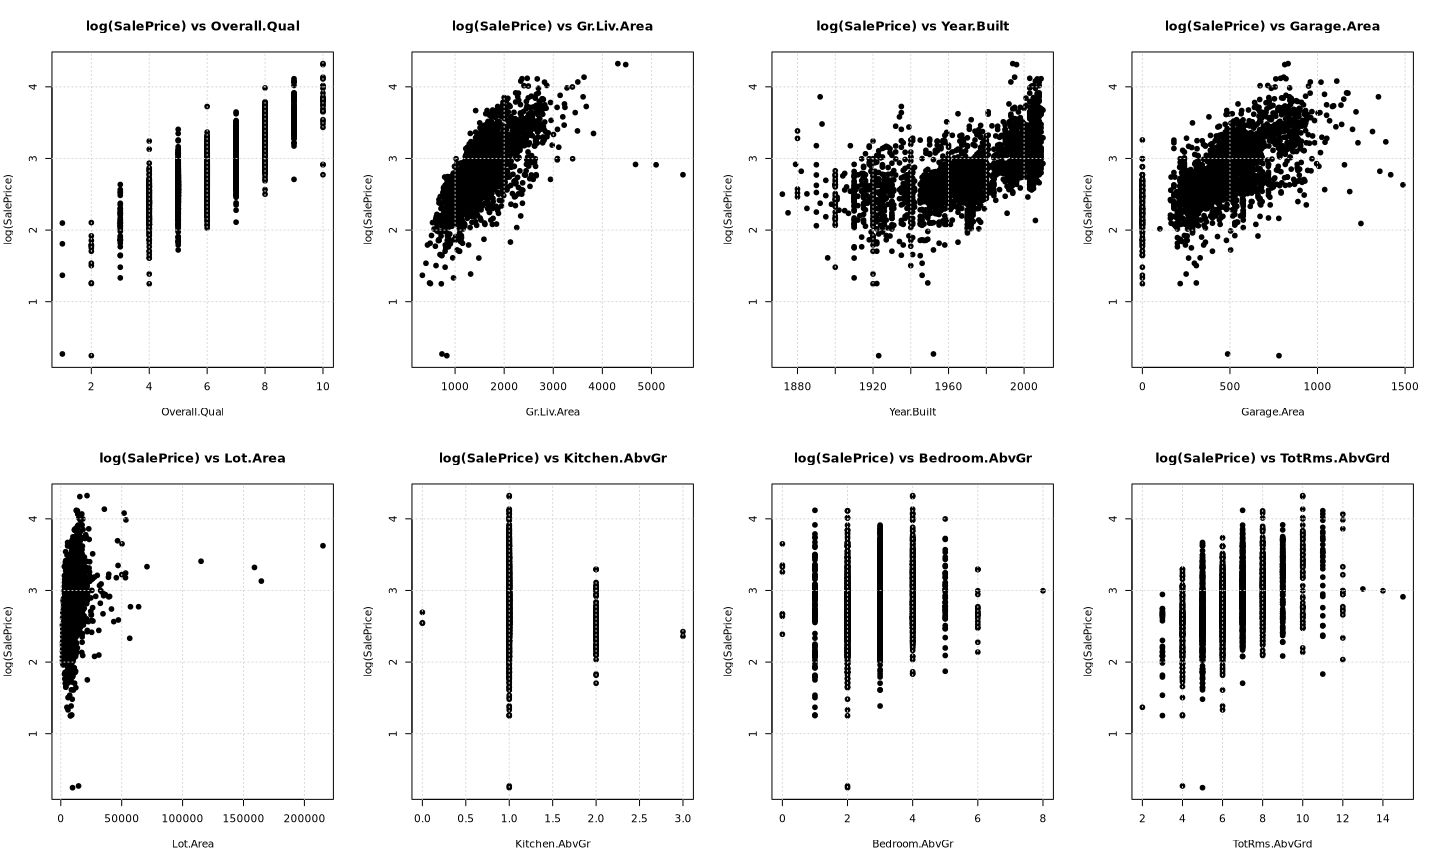

every pair show linear relationship, except for `Year.Built` that still
curved.

fit linear model again with log(Y) as response variable

since `Year.Build` shows quadratic relationship, we use
$$(X_{Year.Built}- \bar{X_{Year.Built}})^2$$  

looks random -\> assumptions aligned! -\> conclusion will be valid

now, transformed model become our final model.

`{# {r} # #| echo: false # #| message: false # #| warning: false # #| output: true # summary(transform_model)`

Top four covariates output remain same. Inferiential question started
from choose from these 4 variables.

1 Overall.Qual  
2 Gr.Liv.Area  
3 Year.Built  
4 Lot.Area

very high adjust R square

## Interaction Term

//TODO confirm if we still need to consider interaction term since all
covariates in best subset model are all positive, no counterintuitive
which full model has counterintuitive term.

## outlier, leverage, influence

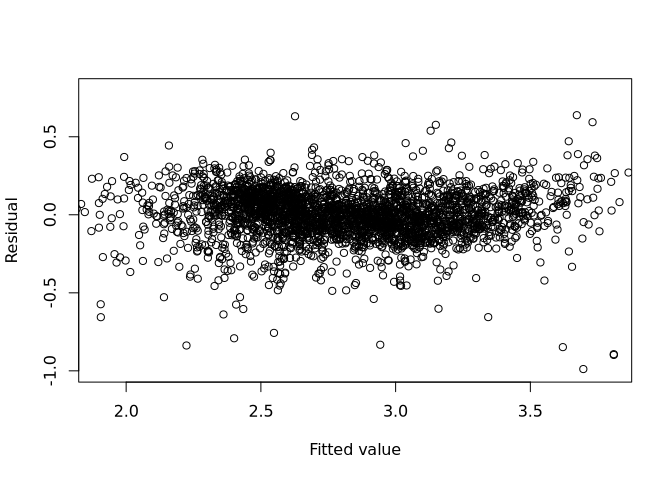

In [ ]:
# options(repr.plot.width = 7, repr.plot.height = 7)
transform_model = lm(log_SalePrice ~ Overall.Qual + 
                       Gr.Liv.Area + I(Gr.Liv.Area^2) +
                       Year.Built + I(Year.Built^2) + 
                       Garage.Area + I(Garage.Area^2) + 
                       Central.Air + Lot.Area + Lot.Shape + 
                       Kitchen.AbvGr + Electrical + Bedroom.AbvGr +
                       Utilities + TotRms.AbvGrd + I(TotRms.AbvGrd^2) , data = house)

plot(x = transform_model$fitted.values, y = transform_model$residuals,
     xlim = c(1.9, 3.8), ylim =c(-1.0, 0.8),
     xlab="Fitted value", ylab="Residual")

In [ ]:
summary(transform_model)


Call:
lm(formula = log_SalePrice ~ Overall.Qual + Gr.Liv.Area + I(Gr.Liv.Area^2) + 
    Year.Built + I(Year.Built^2) + Garage.Area + I(Garage.Area^2) + 
    Central.Air + Lot.Area + Lot.Shape + Kitchen.AbvGr + Electrical + 
    Bedroom.AbvGr + Utilities + TotRms.AbvGrd + I(TotRms.AbvGrd^2), 
    data = house)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.70383 -0.08354  0.00763  0.09956  0.63833 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -3.595e+01  1.397e+01  -2.573  0.01012 *  
Overall.Qual        1.113e-01  3.625e-03  30.699  < 2e-16 ***
Gr.Liv.Area         6.385e-04  3.010e-05  21.211  < 2e-16 ***
I(Gr.Liv.Area^2)   -9.379e-08  7.067e-09 -13.273  < 2e-16 ***
Year.Built          3.592e-02  1.427e-02   2.517  0.01190 *  
I(Year.Built^2)    -8.597e-06  3.644e-06  -2.359  0.01839 *  
Garage.Area         1.832e-04  4.491e-05   4.079 4.64e-05 ***
I(Garage.Area^2)    4.080e-08  4.074e-08   1.002  0.31664    
Central.Air

In [ ]:
simpler_model = lm(log_SalePrice ~ Overall.Qual + 
                       Gr.Liv.Area + I(Gr.Liv.Area^2) +
                       Year.Built + I(Year.Built^2) + 
                       Garage.Area + 
                       Central.Air + Lot.Area + Lot.Shape + 
                       Kitchen.AbvGr + Electrical + Bedroom.AbvGr +
                       Utilities, data = house)
summary(simpler_model)


Call:
lm(formula = log_SalePrice ~ Overall.Qual + Gr.Liv.Area + I(Gr.Liv.Area^2) + 
    Year.Built + I(Year.Built^2) + Garage.Area + Central.Air + 
    Lot.Area + Lot.Shape + Kitchen.AbvGr + Electrical + Bedroom.AbvGr + 
    Utilities, data = house)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.70378 -0.08371  0.00838  0.09999  0.63675 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -3.273e+01  1.379e+01  -2.374  0.01765 *  
Overall.Qual      1.115e-01  3.622e-03  30.768  < 2e-16 ***
Gr.Liv.Area       6.423e-04  2.530e-05  25.390  < 2e-16 ***
I(Gr.Liv.Area^2) -9.278e-08  5.839e-09 -15.889  < 2e-16 ***
Year.Built        3.263e-02  1.408e-02   2.317  0.02056 *  
I(Year.Built^2)  -7.763e-06  3.597e-06  -2.158  0.03098 *  
Garage.Area       2.244e-04  1.832e-05  12.246  < 2e-16 ***
Central.AirY      1.308e-01  1.420e-02   9.216  < 2e-16 ***
Lot.Area          4.588e-06  4.246e-07  10.807  < 2e-16 ***
Lot.ShapeIR2     -3.440e-03  1

  956, 1578, 2240

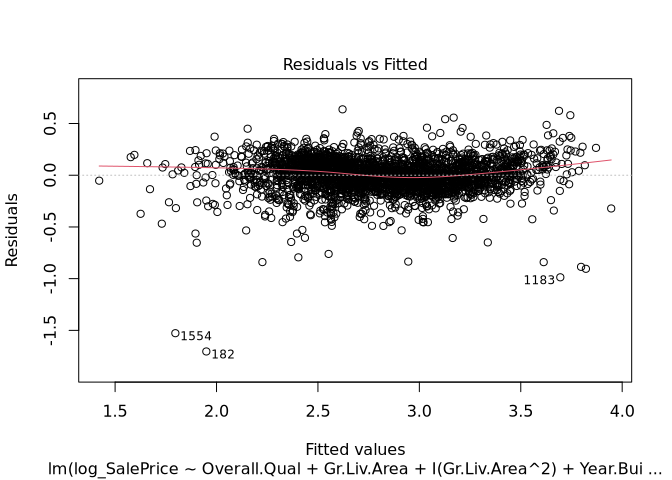

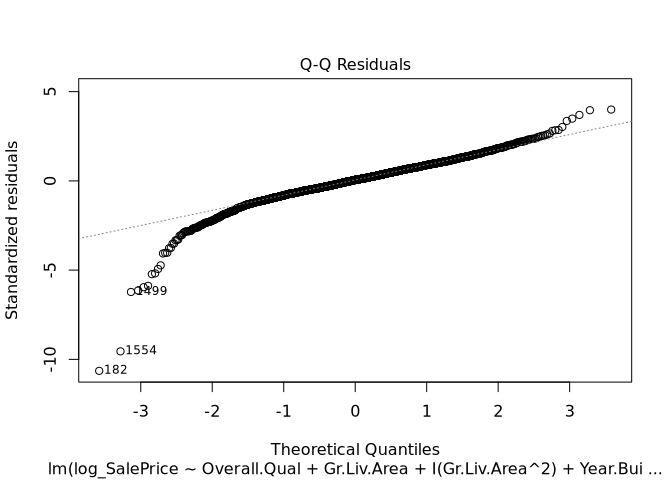

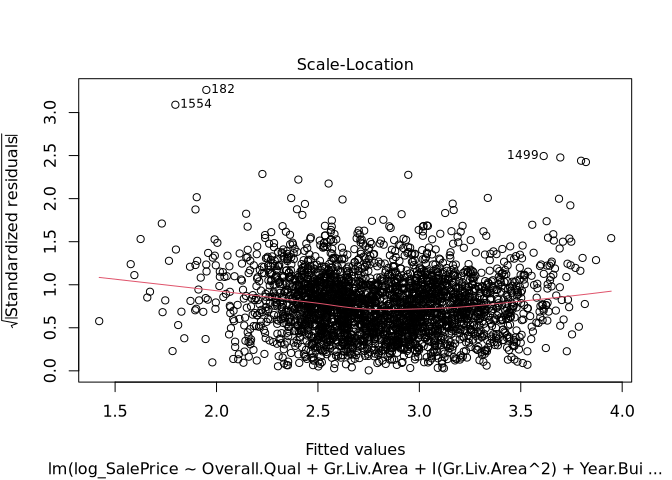

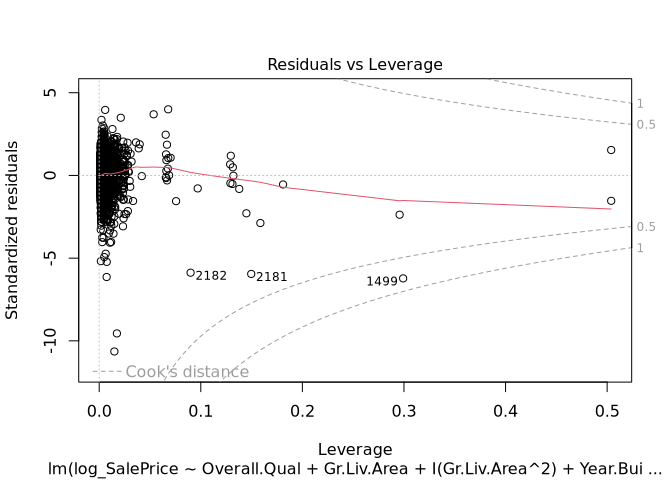

In [ ]:
Y <- house$log_SalePrice
X <- model.matrix( ~ Overall.Qual + Gr.Liv.Area + Year.Built + Year.Built^2 + 
                     Lot.Area + Garage.Area + Kitchen.AbvGr + Lot.Shape + 
                     Bedroom.AbvGr + Central.Air, data = house)
P = X %*% solve(t(X)%*%X, t(X))
n = length(Y)
k = length(coef(simpler_model))
threshold = 2*k/n
plot(simpler_model)

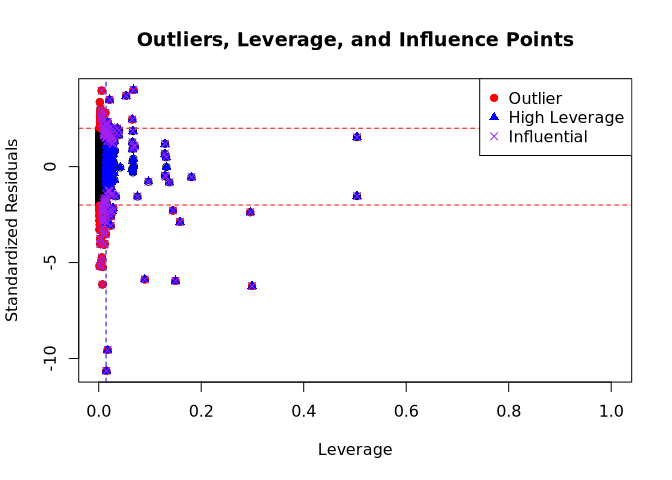

In [ ]:
# 获取诊断数据
influence_data <- influence.measures(simpler_model)
leverage <- hatvalues(simpler_model)
standardized_residuals <- rstandard(simpler_model)
cooks_d <- cooks.distance(simpler_model)

# 阈值设定
n <- nrow(house)
p <- length(coef(simpler_model))  # 包括截距
leverage_threshold <- 2 * p / n
cooks_threshold <- 4 / n

# 画图标注不同点
plot(leverage, standardized_residuals,
     xlab = "Leverage", ylab = "Standardized Residuals",
     main = "Outliers, Leverage, and Influence Points")
abline(h = c(-2, 2), col = "red", lty = 2)
abline(v = leverage_threshold, col = "blue", lty = 2)

# 标出离群点（标准化残差 > 2）
outlier_points <- which(abs(standardized_residuals) > 2)
points(leverage[outlier_points], standardized_residuals[outlier_points], col = "red", pch = 19)

# 标出高杠杆点
leverage_points <- which(leverage > leverage_threshold)
points(leverage[leverage_points], standardized_residuals[leverage_points], col = "blue", pch = 17)

# 标出高影响点（Cook's D）
influence_points <- which(cooks_d > cooks_threshold)
points(leverage[influence_points], standardized_residuals[influence_points], col = "purple", pch = 4)

legend("topright", legend = c("Outlier", "High Leverage", "Influential"),
       col = c("red", "blue", "purple"), pch = c(19, 17, 4))

ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.

`geom_smooth()` using formula = 'y ~ x'

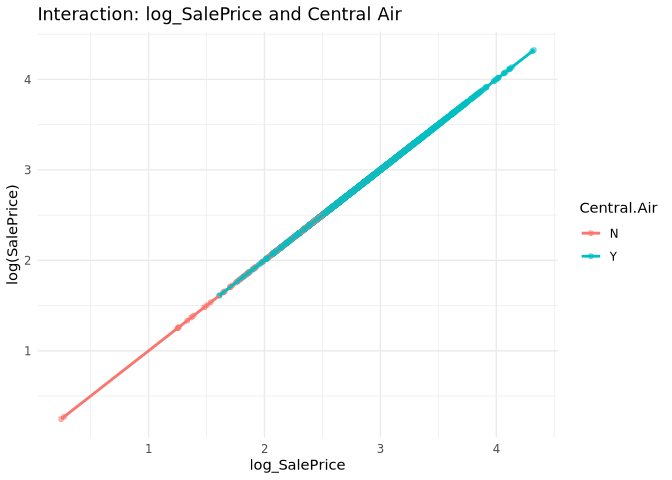

`geom_smooth()` using formula = 'y ~ x'

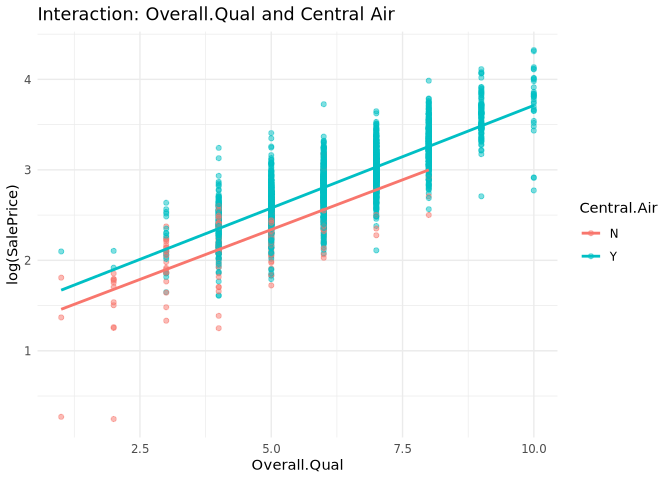

`geom_smooth()` using formula = 'y ~ x'

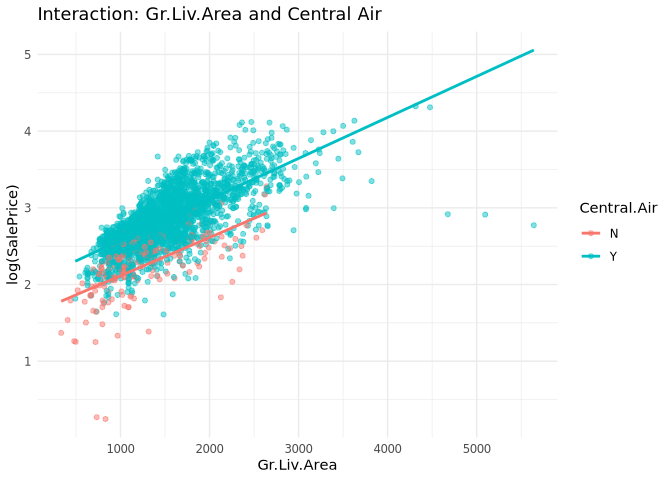

`geom_smooth()` using formula = 'y ~ x'

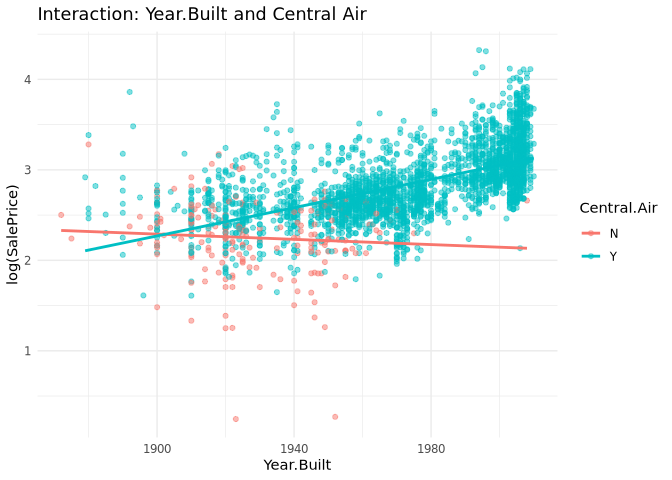

`geom_smooth()` using formula = 'y ~ x'

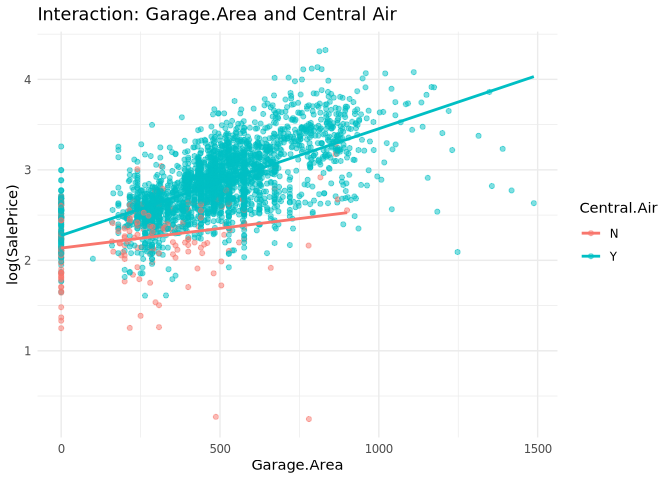

`geom_smooth()` using formula = 'y ~ x'

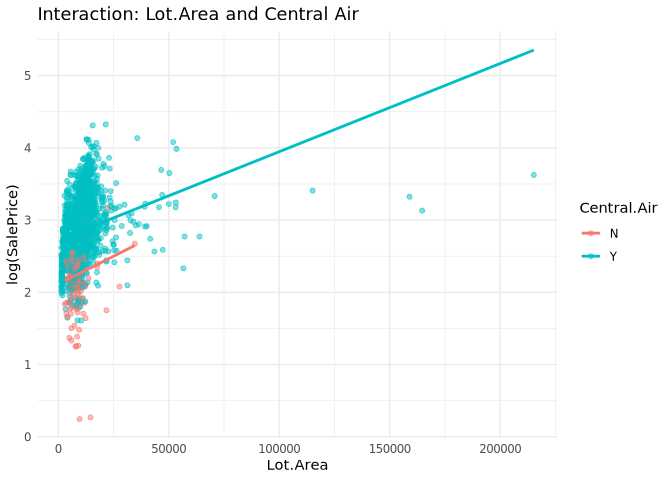

`geom_smooth()` using formula = 'y ~ x'

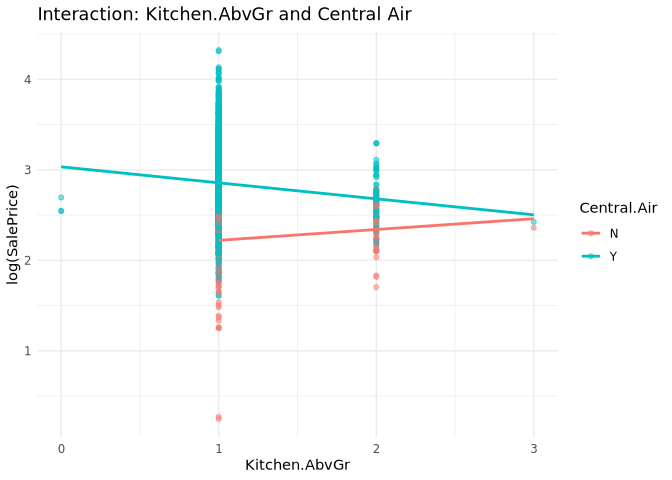

`geom_smooth()` using formula = 'y ~ x'

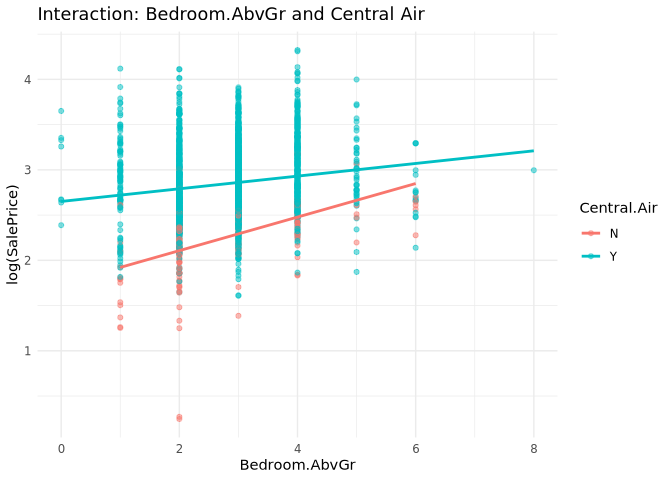

`geom_smooth()` using formula = 'y ~ x'

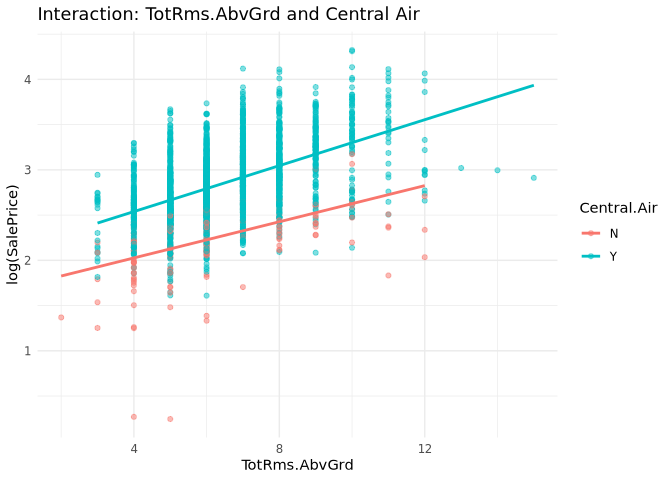

In [ ]:
library(ggplot2)

for (var in names(house_numeric_only)) {
  p <- ggplot(house, aes_string(x = var, y = "log_SalePrice", color = "Central.Air")) +
    geom_point(alpha = 0.5) +
    geom_smooth(method = "lm", se = FALSE) +
    labs(
      title = paste("Interaction:", var, "and Central Air"),
      x = var,
      y = "log(SalePrice)"
    ) +
    theme_minimal()
  print(p)
}

`geom_smooth()` using formula = 'y ~ x'

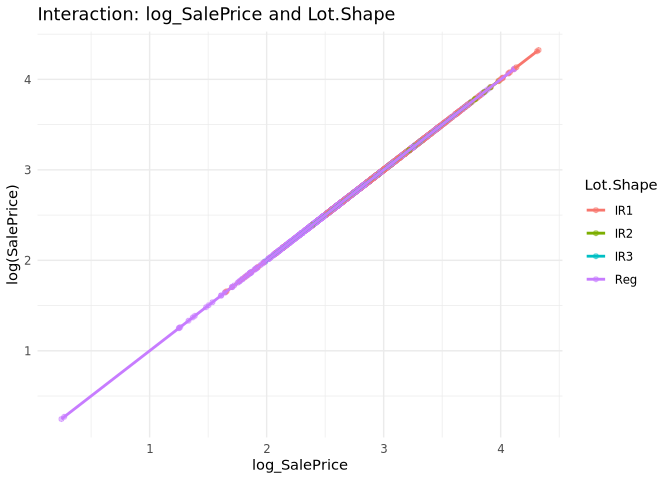

`geom_smooth()` using formula = 'y ~ x'

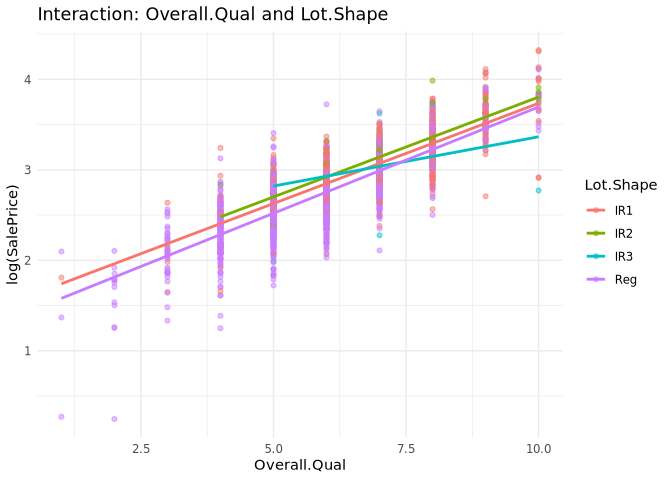

`geom_smooth()` using formula = 'y ~ x'

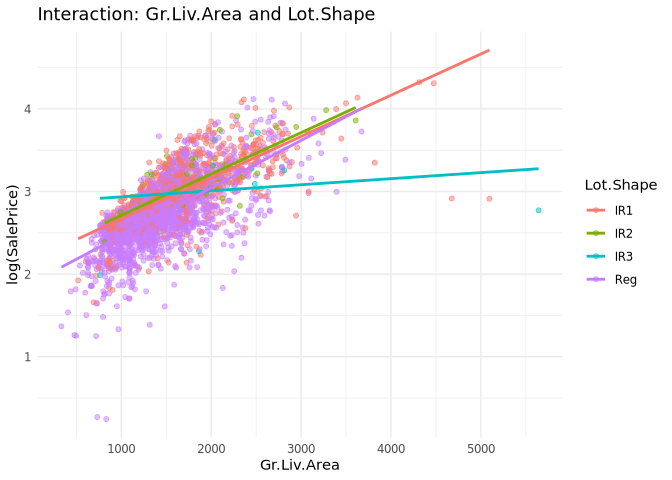

`geom_smooth()` using formula = 'y ~ x'

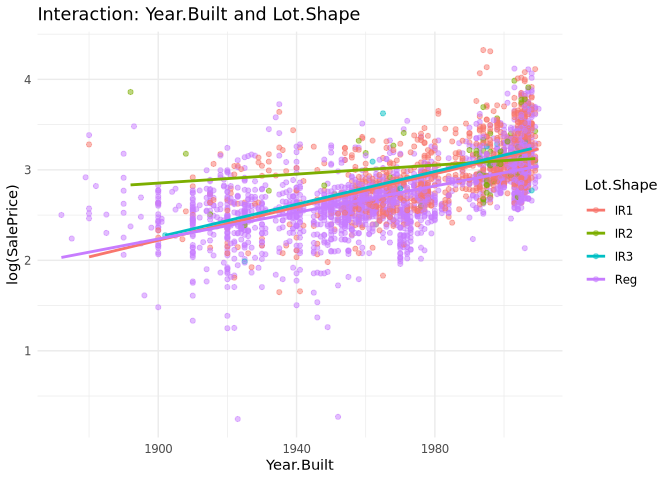

`geom_smooth()` using formula = 'y ~ x'

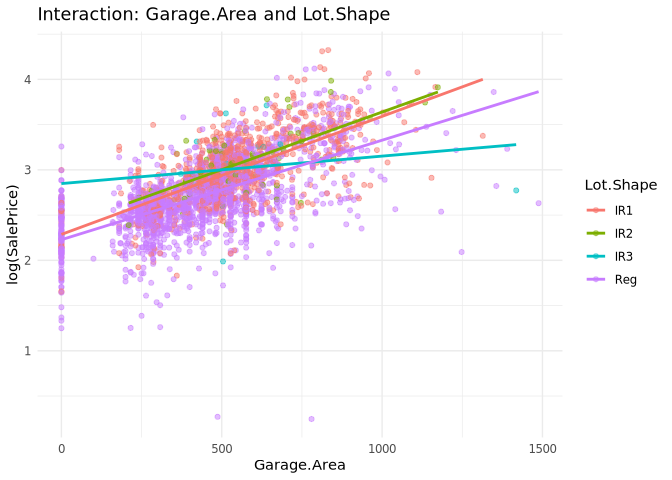

`geom_smooth()` using formula = 'y ~ x'

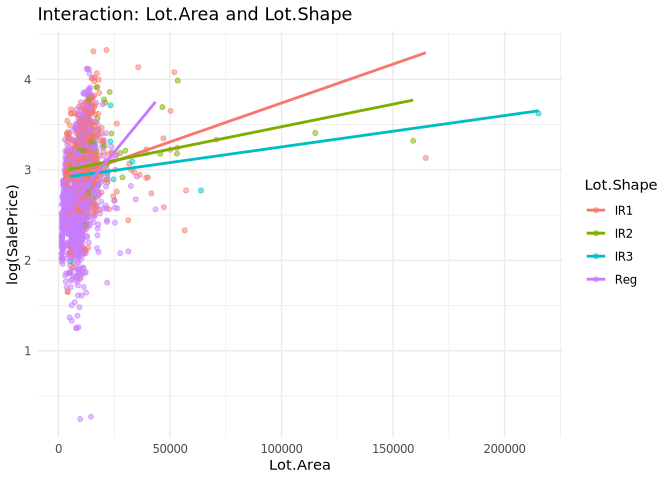

`geom_smooth()` using formula = 'y ~ x'

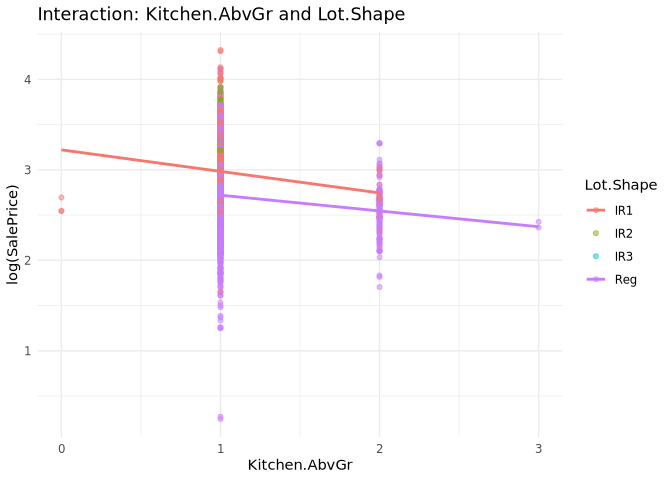

`geom_smooth()` using formula = 'y ~ x'

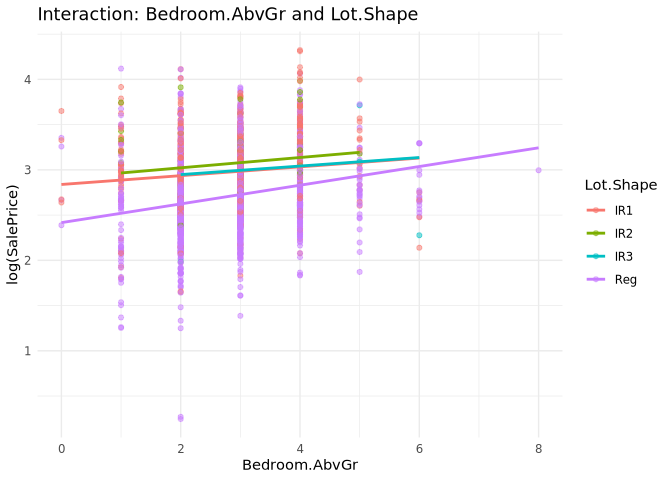

`geom_smooth()` using formula = 'y ~ x'

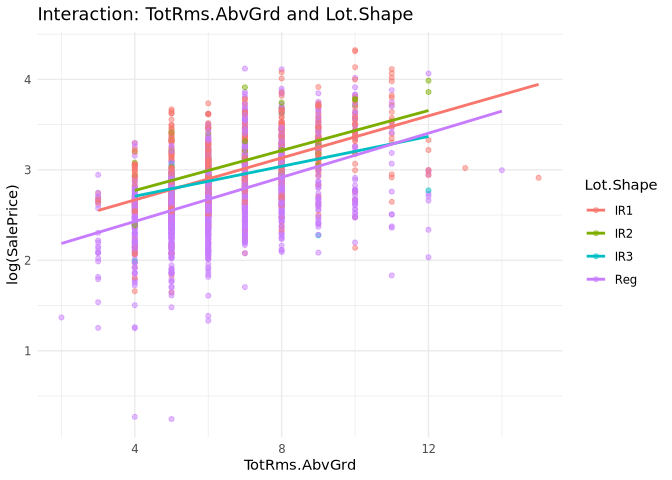

In [ ]:
for (var in names(house_numeric_only)) {
  p <- ggplot(house, aes_string(x = var, y = "log_SalePrice", color = "Lot.Shape")) +
    geom_point(alpha = 0.5) +
    geom_smooth(method = "lm", se = FALSE) +
    labs(
      title = paste("Interaction:", var, "and Lot.Shape"),
      x = var,
      y = "log(SalePrice)"
    ) +
    theme_minimal()
  
  print(p)
}

`geom_smooth()` using formula = 'y ~ x'

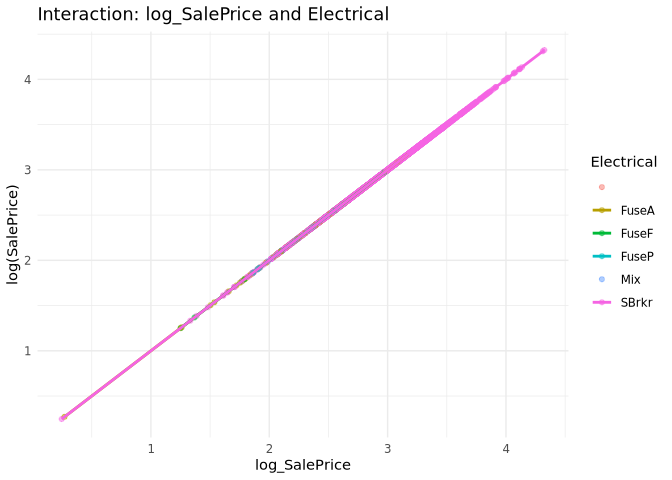

`geom_smooth()` using formula = 'y ~ x'

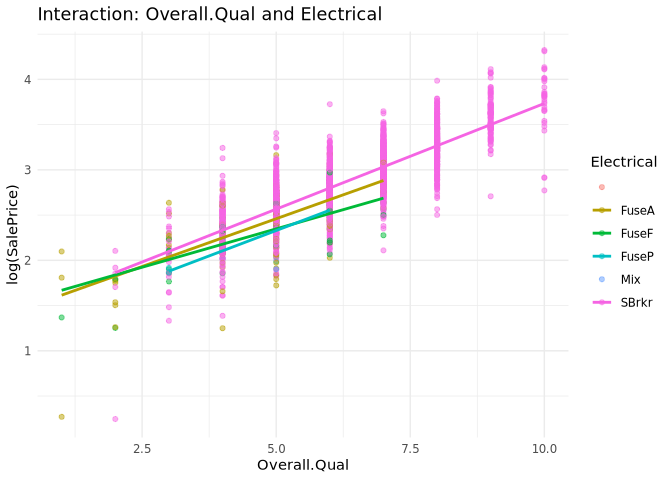

`geom_smooth()` using formula = 'y ~ x'

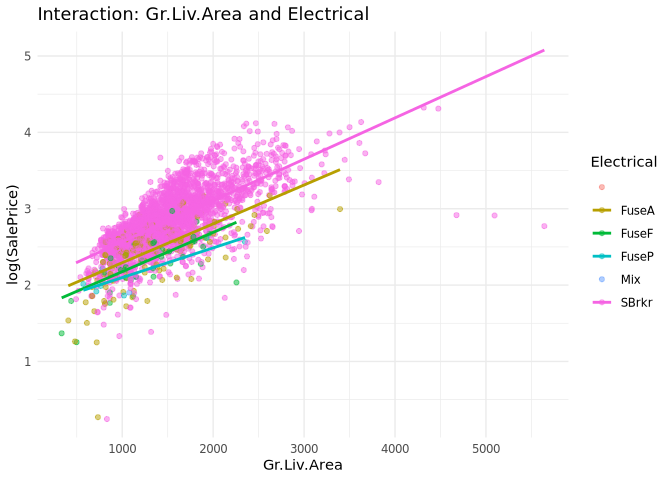

`geom_smooth()` using formula = 'y ~ x'

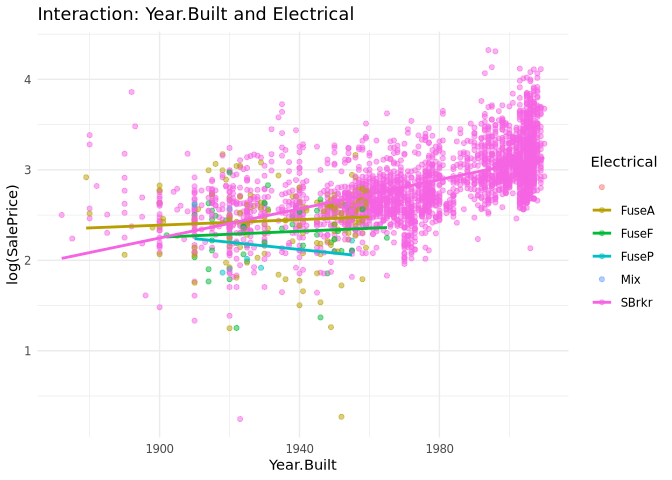

`geom_smooth()` using formula = 'y ~ x'

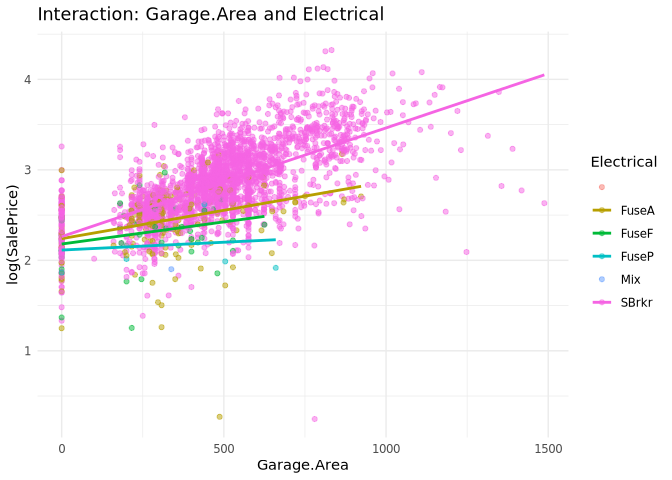

`geom_smooth()` using formula = 'y ~ x'

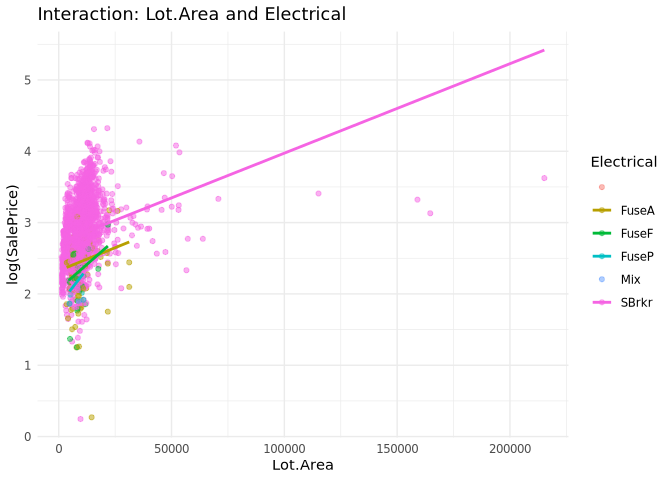

`geom_smooth()` using formula = 'y ~ x'

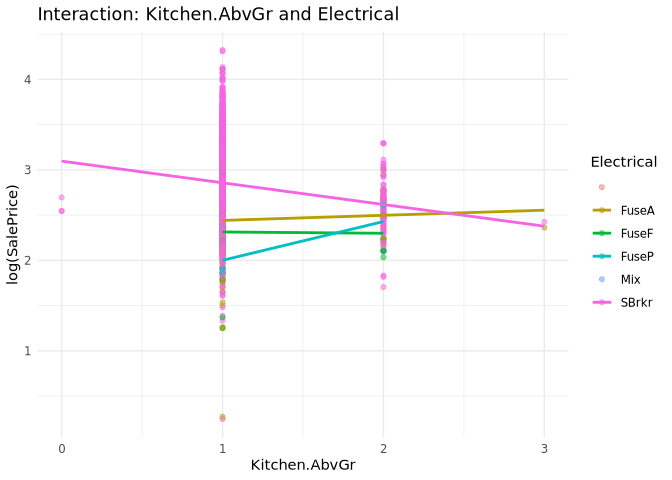

`geom_smooth()` using formula = 'y ~ x'

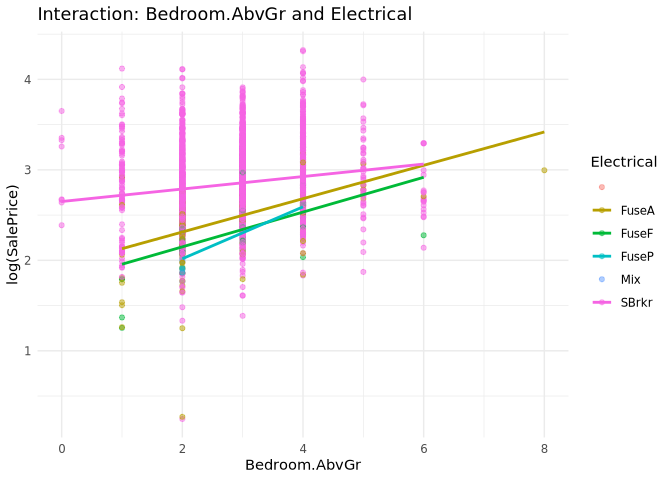

`geom_smooth()` using formula = 'y ~ x'

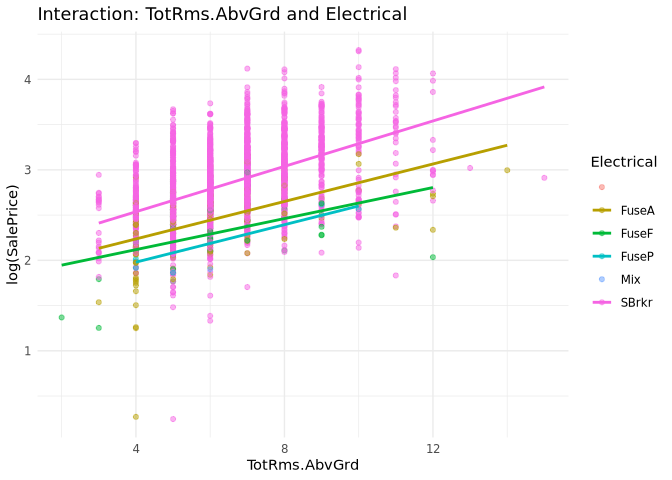

In [ ]:
for (var in names(house_numeric_only)) {
  p <- ggplot(house, aes_string(x = var, y = "log_SalePrice", color = "Electrical")) +
    geom_point(alpha = 0.5) +
    geom_smooth(method = "lm", se = FALSE) +
    labs(
      title = paste("Interaction:", var, "and Electrical"),
      x = var,
      y = "log(SalePrice)"
    ) +
    theme_minimal()
  
  print(p)
}

`geom_smooth()` using formula = 'y ~ x'

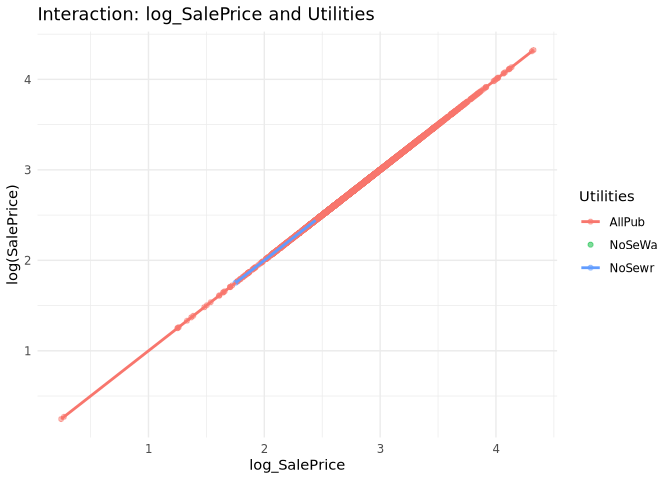

`geom_smooth()` using formula = 'y ~ x'

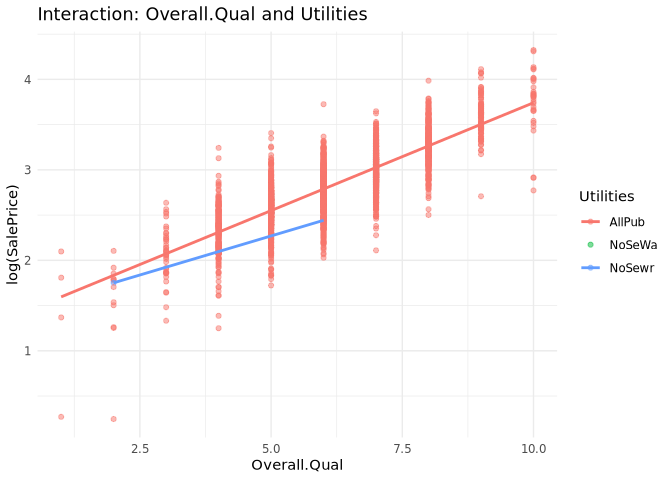

`geom_smooth()` using formula = 'y ~ x'

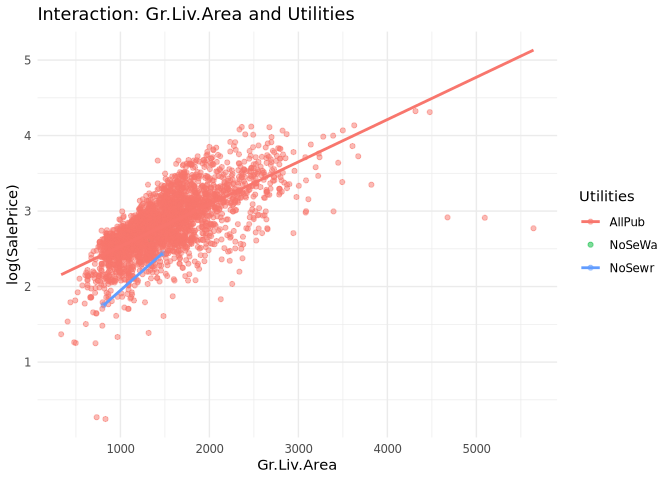

`geom_smooth()` using formula = 'y ~ x'

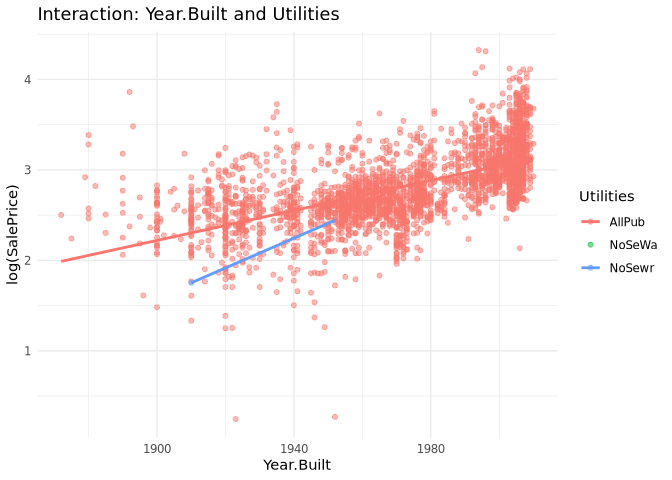

`geom_smooth()` using formula = 'y ~ x'

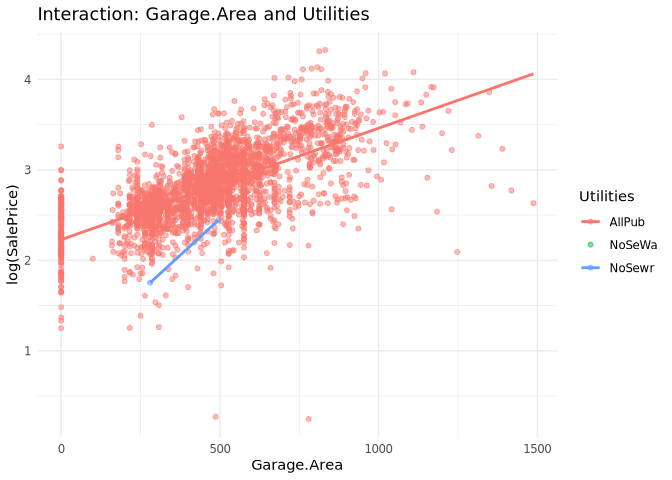

`geom_smooth()` using formula = 'y ~ x'

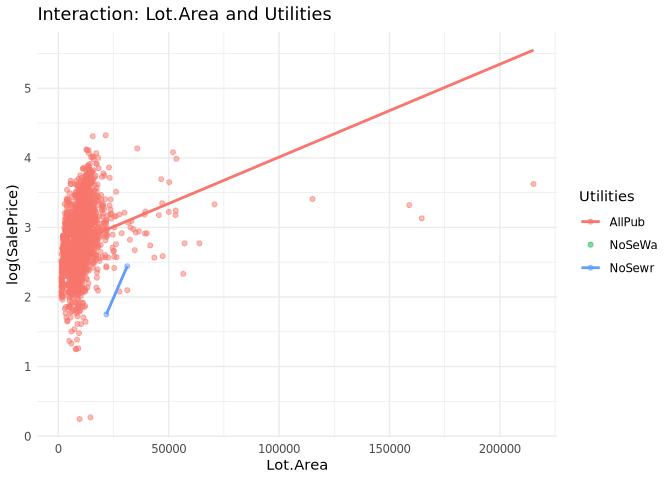

`geom_smooth()` using formula = 'y ~ x'

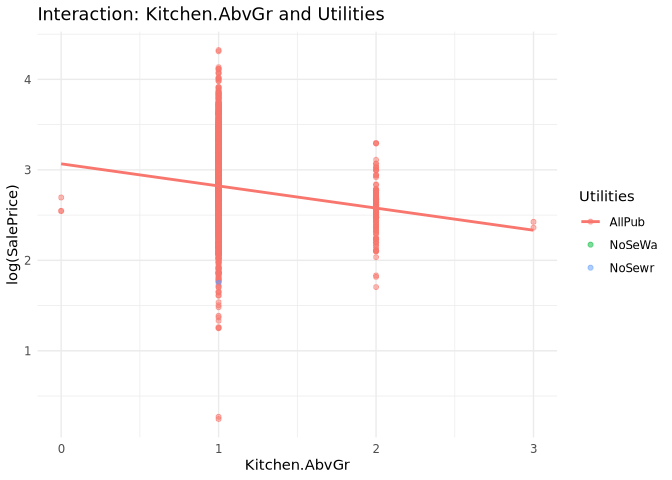

`geom_smooth()` using formula = 'y ~ x'

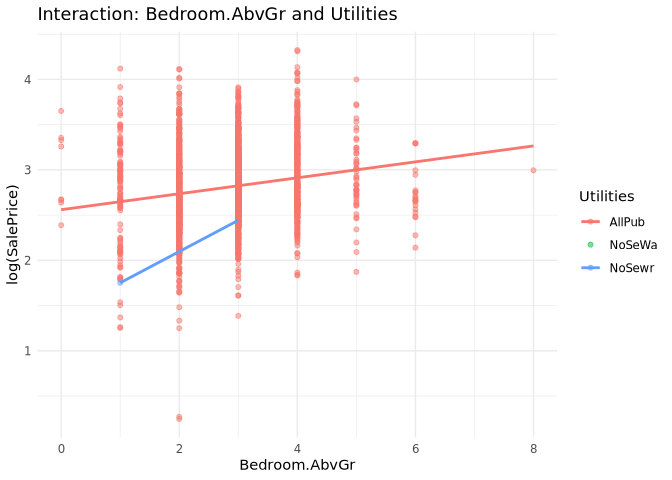

`geom_smooth()` using formula = 'y ~ x'

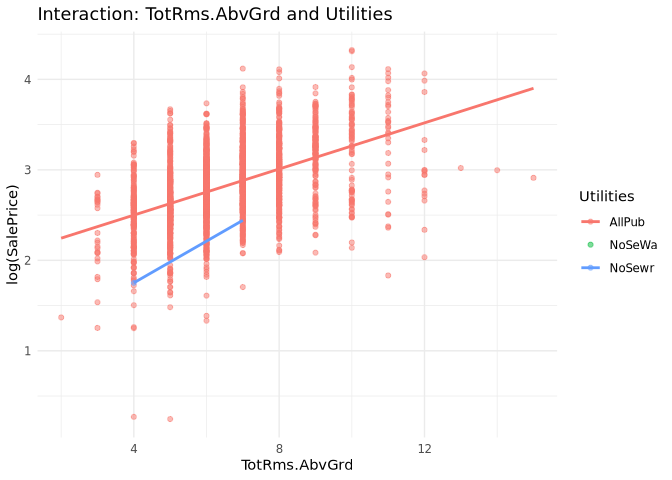

In [ ]:
for (var in names(house_numeric_only)) {
  p <- ggplot(house, aes_string(x = var, y = "log_SalePrice", color = "Utilities")) +
    geom_point(alpha = 0.5) +
    geom_smooth(method = "lm", se = FALSE) +
    labs(
      title = paste("Interaction:", var, "and Utilities"),
      x = var,
      y = "log(SalePrice)"
    ) +
    theme_minimal()
  
  print(p)
}

In [ ]:
inter_model = lm(log_SalePrice ~ 
                   Overall.Qual + Overall.Qual:Utilities+
                   Gr.Liv.Area + I(Gr.Liv.Area^2) + 
                   Gr.Liv.Area:Lot.Shape + I(Gr.Liv.Area^2):Lot.Shape +
                   Gr.Liv.Area:Utilities + I(Gr.Liv.Area^2):Utilities + 
                   Year.Built + I(Year.Built^2) + 
                   Year.Built:Central.Air + I(Year.Built^2):Central.Air +
                   Year.Built:Lot.Shape + I(Year.Built^2):Lot.Shape +
                   Year.Built:Electrical + I(Year.Built^2):Electrical +
                   Year.Built:Utilities + I(Year.Built^2):Utilities +
                   Garage.Area + Garage.Area:Central.Air + Garage.Area:Lot.Shape + 
                   Garage.Area:Electrical + Garage.Area:Utilities + 
                   I(Garage.Area^2) + I(Garage.Area^2):Central.Air + 
                   I(Garage.Area^2):Lot.Shape + I(Garage.Area^2):Electrical + 
                   I(Garage.Area^2):Utilities +
                   Bedroom.AbvGr + Bedroom.AbvGr:Central.Air + 
                   Bedroom.AbvGr:Electrical + Bedroom.AbvGr:Utilities + 
                   Kitchen.AbvGr + Kitchen.AbvGr:Central.Air + 
                   Kitchen.AbvGr:Electrical + Kitchen.AbvGr:Utilities +
                   TotRms.AbvGrd + I(TotRms.AbvGrd^2) +
                   TotRms.AbvGrd:Utilities + I(TotRms.AbvGrd^2):Utilities+
                   Central.Air + Lot.Area + Lot.Shape + Electrical + Utilities, 
                 data = house)
summary(inter_model)


Call:
lm(formula = log_SalePrice ~ Overall.Qual + Overall.Qual:Utilities + 
    Gr.Liv.Area + I(Gr.Liv.Area^2) + Gr.Liv.Area:Lot.Shape + 
    I(Gr.Liv.Area^2):Lot.Shape + Gr.Liv.Area:Utilities + I(Gr.Liv.Area^2):Utilities + 
    Year.Built + I(Year.Built^2) + Year.Built:Central.Air + I(Year.Built^2):Central.Air + 
    Year.Built:Lot.Shape + I(Year.Built^2):Lot.Shape + Year.Built:Electrical + 
    I(Year.Built^2):Electrical + Year.Built:Utilities + I(Year.Built^2):Utilities + 
    Garage.Area + Garage.Area:Central.Air + Garage.Area:Lot.Shape + 
    Garage.Area:Electrical + Garage.Area:Utilities + I(Garage.Area^2) + 
    I(Garage.Area^2):Central.Air + I(Garage.Area^2):Lot.Shape + 
    I(Garage.Area^2):Electrical + I(Garage.Area^2):Utilities + 
    Bedroom.AbvGr + Bedroom.AbvGr:Central.Air + Bedroom.AbvGr:Electrical + 
    Bedroom.AbvGr:Utilities + Kitchen.AbvGr + Kitchen.AbvGr:Central.Air + 
    Kitchen.AbvGr:Electrical + Kitchen.AbvGr:Utilities + TotRms.AbvGrd + 
    I(TotRms.AbvGrd^2)

In [ ]:
inter_simp = lm(log_SalePrice ~
                  Overall.Qual+ Gr.Liv.Area+ I(Gr.Liv.Area^2)+ Garage.Area+ I(Garage.Area^2)+ 
                  TotRms.AbvGrd + I(TotRms.AbvGrd^2) + Electrical + Gr.Liv.Area:Lot.Shape + 
                  I(Gr.Liv.Area^2):Lot.Shape + Central.Air:I(Garage.Area^2) + 
                  Central.Air:Bedroom.AbvGr, data = house)
summary(inter_simp)


Call:
lm(formula = log_SalePrice ~ Overall.Qual + Gr.Liv.Area + I(Gr.Liv.Area^2) + 
    Garage.Area + I(Garage.Area^2) + TotRms.AbvGrd + I(TotRms.AbvGrd^2) + 
    Electrical + Gr.Liv.Area:Lot.Shape + I(Gr.Liv.Area^2):Lot.Shape + 
    Central.Air:I(Garage.Area^2) + Central.Air:Bedroom.AbvGr, 
    data = house)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.53782 -0.08947  0.01032  0.10442  0.72742 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    1.427e+00  1.770e-01   8.062 1.09e-15 ***
Overall.Qual                   1.310e-01  3.274e-03  40.025  < 2e-16 ***
Gr.Liv.Area                    5.563e-04  3.550e-05  15.671  < 2e-16 ***
I(Gr.Liv.Area^2)              -7.049e-08  8.489e-09  -8.304  < 2e-16 ***
Garage.Area                    4.050e-04  4.858e-05   8.336  < 2e-16 ***
I(Garage.Area^2)              -5.768e-07  1.017e-07  -5.673 1.54e-08 ***
TotRms.AbvGrd                  3.275e-02  1.485e-02   2.20